<a href="https://colab.research.google.com/github/KamilS25/ISiT/blob/main/Pr2_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Практическая работа №2**. Граф. Оценка графа.

**Группа**: БСМО-11-25

**Рабочая группа**: Салахетдинов Камиль, Пылин Олег, Дели Валерия, Мокрецов Егор(БСМО-12-25)

В ячейке ниже осуществляется запрос по API ВК для того, чтобы получить данных о всех членах группы. Код был исправлен, чтобы захватывались все возможные связи, то есть учитывались друзья друзей и между ними выстраивались связи. Количество изначальных друзей, которые берутся у нашей группы из 4 человек - 40 (чтобы не ждать выполнение кода очень долго), Вы разрешили так сделать, чтобы показать выполнение задания.

P.S. Код в данной ячейке (его результат) немного поломан, так как хотелось попробовать выполнить для 50-60 людей, чтобы еще увеличить выборку, но почему-то запросы к ВК начали сбоить и невыполняться, но в ячейке с визуализацией видно, что все связи имеются и сколько вышло вершин и ребер.

In [7]:
import requests
import os
import time
from itertools import combinations

def get_user_info(user_id, fields, token, api_version):
    '''
    Получить информацию о человеке по его user_id
    '''
    params = {'user_id': int(user_id),
              'fields': ','.join(fields),
              'name_case': 'Nom',
              'v': api_version,
              'access_token': token}
    url = 'https://api.vk.com/method/users.get'

    try:
        req = requests.get(url, params=params)
        user = req.json()['response'][0]
    except:
        raise ValueError('Wrong user id or server error')

    return user

def make_dict_from_user_info(user, user_type):
    '''
    Обработать API ответ от сервера для удобного отображения
    '''
    user_info = {}

    user_info['id'] = str(user['id'])
    user_info['name'] = (user['first_name'] + ' ' + user['last_name']).strip()
    user_info['type'] = str(user_type)
    user_info['domain'] = 'vk.com/' + user['domain']

    return user_info

def make_node_from_user_info(user_info):
    # Преобразовать словарь с информацией о человеке в вершину графа
    new_node = []
    for key in user_info:
        new_node.append(str(user_info[key]))
    new_node = ','.join(new_node)
    return new_node

def write_to_csv(filename, fields, rows):
    '''
    Записать информацию в csv файл
    '''
    with open(filename, 'w', encoding='utf-8') as file:
        file.write(fields + '\n')
        for row in rows:
            file.write(row + '\n')

def request_friends(user_id, count, fields, token, api_version):
    '''
    Получить список друзей человека по его user_id
    '''
    url = 'https://api.vk.com/method/friends.get'
    params = {'v': api_version,
              'access_token': token,
              'user_id': user_id,
              'count': count,
              'fields': ','.join(fields)}
    return requests.get(url, params=params).json()['response']

def get_mutual_friends(source_uid, target_uid, token, api_version):
    '''
    Получить общих друзей между двумя пользователями
    '''
    url = 'https://api.vk.com/method/friends.getMutual'
    params = {'v': api_version,
              'access_token': token,
              'source_uid': source_uid,
              'target_uid': target_uid}
    try:
        response = requests.get(url, params=params).json()
        if 'response' in response:
            return response['response']
        else:
            return []
    except:
        return []

def get_mutual_friends_batch(source_uid, target_uids, token, api_version):
    '''
    Получить общих друзей между одним пользователем и списком других пользователей
    '''
    url = 'https://api.vk.com/method/friends.getMutual'
    params = {'v': api_version,
              'access_token': token,
              'source_uid': source_uid,
              'target_uids': ','.join(target_uids)}
    try:
        response = requests.get(url, params=params).json()
        if 'response' in response:
            return response['response']
        else:
            return []
    except:
        return []

def get_user_info_batch(user_ids, fields, token, api_version):
    '''
    Получить информацию о нескольких пользователях за один запрос
    '''
    url = 'https://api.vk.com/method/users.get'
    params = {
        'user_ids': ','.join(user_ids),
        'fields': ','.join(fields),
        'v': api_version,
        'access_token': token
    }
    try:
        response = requests.get(url, params=params).json()
        if 'response' in response:
            return response['response']
        else:
            return []
    except:
        return []

# Инициализация токена
token = "63353a6463353a6463353a6430600efaf86633563353a640bc770f01f0254604d410cf0"

# Версия API и запрашиваемые поля
version = '5.131'
fields = ['sex', 'bdate', 'city', 'country', 'domain']

# Инициализация
user_id = "61398554"

try:
    user = get_user_info(user_id, fields, token, version)
    user = make_dict_from_user_info(user, 'me')
except ValueError:
    print("Ошибка получения информации о пользователе")
    exit()

print('Ваше имя:', user.get('name'))

# Ограничиваем количество друзей до 40
count = 40
print(f'Будет получено до {count} друзей для каждого пользователя')

# ID Группы
team = ['240256443', '488546338', '326869471']

print('Получение информации о группе...')

# Словарь для хранения всех пользователей
all_users = {}
all_users[user_id] = user

# Получаем информацию о группе
target_friends = []
for friend_id in team:
    try:
        friend_data = get_user_info(friend_id, fields, token, version)
        friend_info = make_dict_from_user_info(friend_data, 'target_friend')
        all_users[friend_id] = friend_info
        target_friends.append(friend_info)
        print(f'Получена информация о: {friend_info["name"]}')
        time.sleep(0.5)
    except Exception as e:
        print(f'Ошибка получения информации о {friend_id}: {e}')

print('Получение моих друзей...')
try:
    my_friends_response = request_friends(user_id, count, fields, token, version)
    my_friends = my_friends_response['items']
    print(f'Количество моих друзей: {len(my_friends)}')

    # Добавляем друзей в all_users
    for friend in my_friends:
        friend_info = make_dict_from_user_info(friend, 'my_friend')
        all_users[str(friend['id'])] = friend_info
except Exception as e:
    print(f'Ошибка получения моих друзей: {e}')
    my_friends = []

# Получаем друзей для каждого пользователя из группы
print('Получение друзей для группы...')
for target_friend in team:
    try:
        friend_friends_response = request_friends(target_friend, count, fields, token, version)
        friend_friends = friend_friends_response['items']

        # Добавляем друзей человека из группы в all_users
        for ffriend in friend_friends:
            ffriend_id = str(ffriend['id'])
            if ffriend_id not in all_users:
                ffriend_info = make_dict_from_user_info(ffriend, 'friend_of_target')
                all_users[ffriend_id] = ffriend_info

        time.sleep(0.5)
    except Exception as e:
        pass

#Получаем друзей друзей для всех пользователей
print('Получение друзей друзей...')
current_users = list(all_users.keys())
for current_user in current_users:
    try:
        user_friends_response = request_friends(current_user, count, fields, token, version)
        user_friends = user_friends_response['items']

        # Добавляем друзей друзей в all_users
        for ufriend in user_friends:
            ufriend_id = str(ufriend['id'])
            if ufriend_id not in all_users:
                ufriend_info = make_dict_from_user_info(ufriend, 'friend_of_friend')
                all_users[ufriend_id] = ufriend_info

        time.sleep(0.5)
    except Exception as e:
        pass

print('Построение связей...')

# Создаем списки для вершин и ребер
nodes = []
edges = []

# Добавляем всех пользователей в список вершин
for user_data in all_users.values():
    nodes.append(make_node_from_user_info(user_data))

#Строим все возможные связи между пользователями
print('Создание рёбер графа...')
user_ids = list(all_users.keys())

# Создаем связи для всех пользователей и их друзей
for user_id in user_ids:
    try:
        friends_response = request_friends(user_id, count, fields, token, version)
        friends = friends_response['items']

        for friend in friends:
            friend_id = str(friend['id'])
            if friend_id in all_users:
                # Проверяем, нет ли уже такого ребра (в обе стороны)
                edge1 = f"{user_id},{friend_id},1"
                edge2 = f"{friend_id},{user_id},1"
                if edge1 not in edges and edge2 not in edges:
                    edges.append(edge1)

        time.sleep(0.34)  # Задержка для соблюдения лимитов API
    except Exception as e:
        continue

print('\nЗапись данных в файлы...')

# Записываем вершины
print(f'Количество вершин: {len(nodes)}. Запись в файл nodes.csv')
write_to_csv('nodes.csv', 'id,label,type,domain', nodes)

# Записываем ребра
print(f'Количество рёбер: {len(edges)}. Запись в файл edges.csv')
write_to_csv('edges.csv', 'source,target,weight', edges)

print('\nСтатистика графа:')
print(f'- Всего пользователей: {len(all_users)}')
print(f'- Я: 1')
print(f'- Группа: {len(team)}')
print(f'- Мои друзья: {len(my_friends)}')
print(f'- Всего связей: {len(edges)}')

Ваше имя: Kamil Salakhetdinov
Будет получено до 40 друзей для каждого пользователя
Получение информации о группе...
Получена информация о: Egor Mokretsov
Получена информация о: Oleg Pylin
Получена информация о: Valeria Deli
Получение моих друзей...
Ошибка получения моих друзей: 'response'
Получение друзей для группы...
Получение друзей друзей...
Построение связей...
Создание рёбер графа...

Запись данных в файлы...
Количество вершин: 4. Запись в файл nodes.csv
Количество рёбер: 0. Запись в файл edges.csv

Статистика графа:
- Всего пользователей: 4
- Я: 1
- Группа: 3
- Мои друзья: 0
- Всего связей: 0


Ячейка с визуализацией графа и оценкой по 3-ем метрикам, граф получился переполненный, так как очень много вершин и ребер (относительно много), но на нем видно, что связи между друзьями друзей тоже есть. Также есть и те люди, которые имеют общих только с членом группы, но это можно объяснить тем, что у человека может быть человек в друзьях, у которого больше нет общих связей ни с кем из представителей (т.к. на 4-ый "уровень глуюины" мы не залазили). Вы сказали, что достаточно будет найти связи между друзьями друзей.

Количество узлов: 2815
Количество рёбер: 3643

Далее строим граф и выполняем оценку центральности графа 3-мя метриками:

1. По посредничеству: мера центральности в графе, основанная на кратчайших путях. Равна числу этих кратчайших путей через вершину.

2. По близости: мера, которая выражает, насколько близко узел расположен к остальным узлам сети.

3. Собственного вектора: мера центральности вершины в графе, которая учитывает количество и качество соединений узла. Учитывает, насколько тесно узел связан с другими хорошо связанными узлами.


Топ-5 по центральности близости:
------------------------------------------------------------
 1. Kamil Salakhetdinov       | me              | closeness: 0.357744
 2. Egor Mokretsov            | target_friend   | closeness: 0.323658
 3. Oleg Pylin                | target_friend   | closeness: 0.302882
 4. Valeria Deli              | target_friend   | closeness: 0.288896
 5. Alexey Menshenin          | friend_of_target | closeness: 0.268785

Топ-5 по центральности посредничества:
------------------------------------------------------------
 1. Kamil Salakhetdinov       | me              | betweenness: 0.590031
 2. Egor Mokretsov            | target_friend   | betweenness: 0.440903
 3. Oleg Pylin                | target_friend   | betweenness: 0.367218
 4. Valeria Deli              | target_friend   | betweenness: 0.208746
 5. Alexey Menshenin          | friend_of_target | betweenness: 0.063688

Топ-5 по собственному вектору:
------------------------------------------------------------

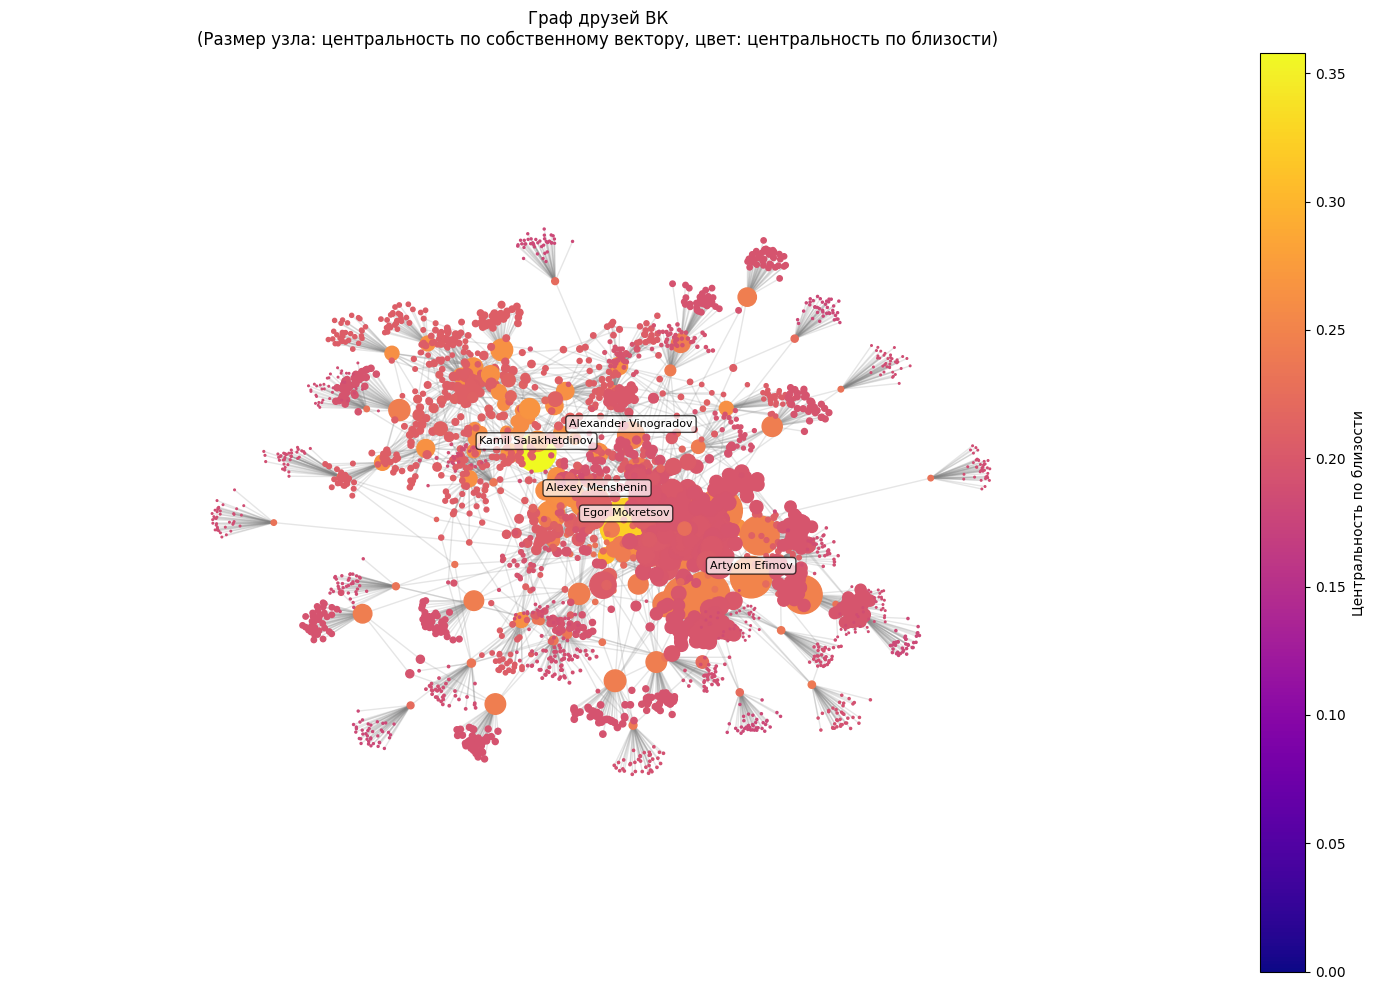

Количество узлов: 2815
Количество рёбер: 3643


In [4]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Загрузка данных
edges = pd.read_csv('edges.csv')
nodes = pd.read_csv('nodes.csv', on_bad_lines='skip')

# Создание графа
G = nx.Graph()

# Добавление узлов с атрибутами
for _, row in nodes.iterrows():
    G.add_node(row['id'],
               label=row['label'],
               type=row['type'],
               domain=row['domain'])

# Добавление рёбер
for _, row in edges.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['weight'])

# Вычисление центральности близости/посредничеству/собственному вектору
closeness = nx.closeness_centrality(G)
betweenness = nx.betweenness_centrality(G, weight='weight')
eigenvector = nx.eigenvector_centrality(G, weight='weight', max_iter=1000)

# Добавили результат в общую таблицу
centrality_df = pd.DataFrame({
    'node': list(closeness.keys()),
    'closeness': list(closeness.values()),
    'betweenness': list(betweenness.values()),
    'eigenvector': list(eigenvector.values())
})

# Добавление информации об узлах
node_info = nodes[['id', 'label', 'type']].drop_duplicates(subset=['id'])
centrality_df = centrality_df.merge(node_info, left_on='node', right_on='id', how='left')
centrality_df = centrality_df.drop('id', axis=1)

# Сортировка по степени центральности
closeness_sorted = centrality_df.sort_values('closeness', ascending=False)
betweenness_sorted = centrality_df.sort_values('betweenness', ascending=False)
eigenvector_sorted = centrality_df.sort_values('eigenvector', ascending=False)

# Вывод топ-5 узлов по каждой метрике
print("\nТоп-5 по центральности близости:")
print("-" * 60)
for i, (_, row) in enumerate(closeness_sorted.head(5).iterrows(), 1):
    print(f"{i:2d}. {row['label']:25} | {row['type']:15} | closeness: {row['closeness']:.6f}")

print("\nТоп-5 по центральности посредничества:")
print("-" * 60)
for i, (_, row) in enumerate(betweenness_sorted.head(5).iterrows(), 1):
    print(f"{i:2d}. {row['label']:25} | {row['type']:15} | betweenness: {row['betweenness']:.6f}")

print("\nТоп-5 по собственному вектору:")
print("-" * 60)
for i, (_, row) in enumerate(eigenvector_sorted.head(5).iterrows(), 1):
    print(f"{i:2d}. {row['label']:25} | {row['type']:15} | eigenvector: {row['eigenvector']:.6f}")

# Отображение графа моих друзей из VK
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)
closeness_values = list(closeness.values())
vmin = min(closeness_values)
vmax = max(closeness_values)

nodes_draw = nx.draw_networkx_nodes(
    G, pos,
    node_size=[v * 5000 for v in eigenvector.values()],
    node_color=closeness_values,
    cmap=plt.cm.plasma,
    vmin=vmin,
    vmax=vmax
)
nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color='gray')

plt.colorbar(nodes_draw, label='Центральность по близости')
rank_df = centrality_df.copy()
rank_df['closeness_rank'] = rank_df['closeness'].rank(ascending=False)
rank_df['betweenness_rank'] = rank_df['betweenness'].rank(ascending=False)
rank_df['eigenvector_rank'] = rank_df['eigenvector'].rank(ascending=False)
rank_df['avg_rank'] = (rank_df['closeness_rank'] + rank_df['betweenness_rank'] + rank_df['eigenvector_rank']) / 3

# Добавляем подписи для топ-5 самых центральных узлов
top_labels = {}
top_overall = rank_df.sort_values('avg_rank').head(5)
for _, row in top_overall.head(5).iterrows():
    node_id = row['node']
    if node_id in pos:
        top_labels[node_id] = row['label']

for node_id, label in top_labels.items():
    x, y = pos[node_id]
    plt.text(x, y + 0.02, label, fontsize=8, ha='center',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

plt.title('Граф друзей ВК\n(Размер узла: центральность по собственному вектору, цвет: центральность по близости)')
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Количество узлов: {G.number_of_nodes()}")
print(f"Количество рёбер: {G.number_of_edges()}")